# Time-GPT Time Series Forecasting

In [5]:
import numpy as np
import pandas as pd

from nixtla import NixtlaClient
from utilsforecast.losses import mae

* Nixtla API call

In [6]:
nixtla_client = NixtlaClient(
    api_key='nixak-hhwKgJ3w7LbUnYYK2CYfLjWn6TtssMalGrtI0OATL8nWH4ZQJc2GYUbQeErz27GycnJaM9BNDbDrhE61'
)

* Load dataset

In [ ]:
df = pd.read_csv('/Users/fanisbak/Documents/visitors.csv')
df = df[['datetime','visitors']]
df.rename(columns={'datetime': 'ds', 'visitors': 'y'}, inplace=True)
df.head()

,ds,y
0,2023-01-03 09:00:00,41.0
1,2023-01-03 10:00:00,115.0
2,2023-01-03 11:00:00,165.0
3,2023-01-03 12:00:00,163.0
4,2023-01-03 13:00:00,117.0


### Data preparation
The dataset contains only 12 hours per day (due to the time that stores are open), but the model needs full time series data. So, we add the rest hours in the `ds` column.

In [8]:
# Ensure datetime format
df['ds'] = pd.to_datetime(df['ds'])

# Set index and resample hourly
df = df.set_index('ds')

# Reindex over full hourly range between min and max
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')
df = df.reindex(full_range)

# Reset index and rename back
df = df.rename_axis('ds').reset_index()

Then, we have to fill in the NaNs that were created from the previous step in `y` column. We fill with `0` beacause there are no visitors these hours.

In [9]:
df.fillna({'y' : 0}, inplace=True)

This model aslo needs an `id` column so we add one and then check if NaNs exists in our dataset.

In [10]:
df['unique_id'] = 'id1'
df = df[['unique_id', 'ds', 'y']]

In [11]:
df.isna().sum()

unique_id    0
ds           0
y            0
dtype: int64

Create `is_sunday` column.

In [12]:
import pandas as pd

# Make sure the 'timestamp' column is a datetime type
df['ds'] = pd.to_datetime(df['ds'])

# Create a new column that is 1 when it's Sunday (weekday == 6), else 0
df['is_sunday'] = (df['ds'].dt.weekday == 6).astype(int)


## Set the dates were the store is closed

During holidays the stores are closed so in order for the model to know about it we can create an `Exogenous` variable to make it understand when the store is closed and when it is open. Here is an example for the dates of $Christmas$ and $New Year's$ holidays.

In [13]:
closed_dates = pd.to_datetime([
'2020-12-26','2021-12-26','2022-12-26','2023-12-26','2024-12-26', '2025-12-26',
'2020-12-25','2021-12-25','2022-12-25','2023-12-25','2024-12-25','2025-12-25',
'2020-01-01','2021-01-01','2022-01-01','2023-01-01','2024-01-01','2025-01-01',
'2020-01-02','2021-01-02','2022-01-02','2023-01-02','2024-01-02','2025-01-02',
'2024-01-14',
'2024-01-21',
'2024-04-28',
'2024-07-14',
'2024-12-01',
'2024-12-15',
'2024-12-22',
'2024-12-29',
])

df['store_closed'] = df['ds'].dt.normalize().isin(closed_dates).astype(int)
df.loc[df['y'] == 0, 'store_closed'] = 1

When it is Sunday and we have visitors we set `store_closed = 0` ($False$), meaning that the store this Sunday is open, while all other Sundays it is closed.

In [14]:
df.loc[
    (df['is_sunday'] == 1) &
    (df['ds'].dt.hour >= 9) &
    (df['ds'].dt.hour <= 21) &
    (df['y'] != 0),
    'store_closed'
] = 0

The last step for the data preperation fase is to split the dataset in `training` and `test`. \
We want to predict the visitors of the next week (6 days) so we need the last (7 $days$ x 24 $hours$) = `168 hours` from the dataset. \
We can also use the whole other dataset to train the model.

In [15]:
train_df = df[:-168]
test_df = df[-168:]

# Predicting with Time-GPT model

`df` is the training dataset
`X_df` is future Exogenous variables

We `finetune` the model for better precision and use `MAE` (Mean Absolute Error) as the loss function.

We also use `one_hot` feature variables to help the model understand time series patterns like dayofyear, dayofweek etc.

In [ ]:
fcst_df = nixtla_client.forecast(
    df=train_df,
    X_df=test_df[['unique_id', 'ds', 'is_sunday', 'store_closed']],
    h=168,
    level=[90],
    finetune_steps=600,
    finetune_loss='mae',
    model='timegpt-1-long-horizon',
    time_col='ds',
    target_col='y',
    date_features_to_one_hot=True,
    date_features=['dayofyear','dayofweek','month', 'day','week','year', 'hour'],
)

* Now we can plot the prediction.

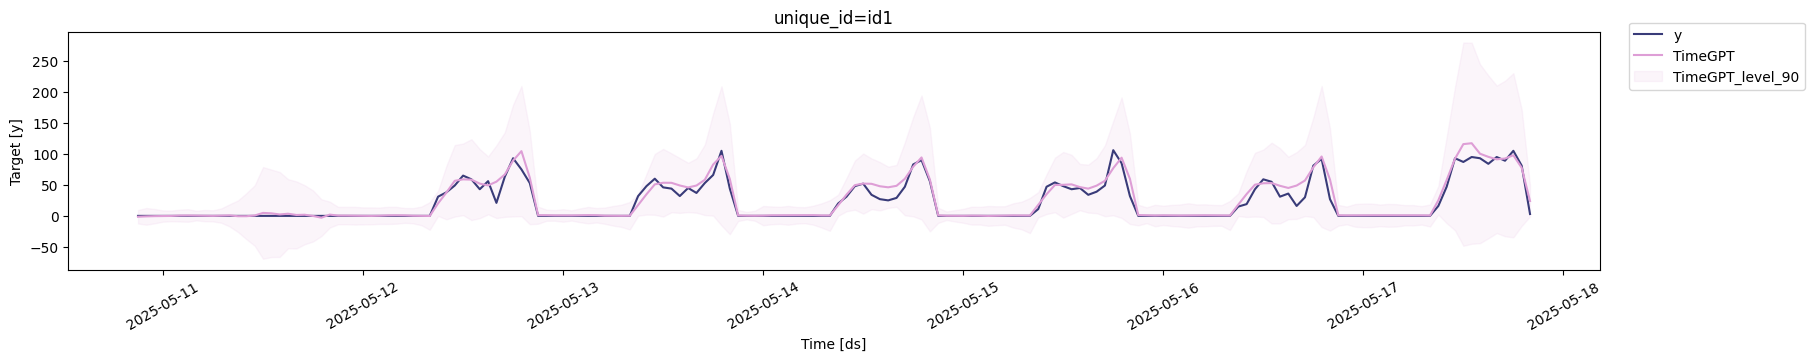

In [ ]:
nixtla_client.plot(
    df[-168:], 
    fcst_df, 
    models=['TimeGPT'], 
    level=[90],
    time_col='ds', 
    target_col='y',
    plot_anomalies=True
)

# Evaluation
We use `Mean Absolute Error (MAE)` to evaluate the model.

In [ ]:
test = test_df.copy()
test.loc[:, 'TimeGPT'] = fcst_df['TimeGPT'].values

evaluation = mae(
    test,
    models=['TimeGPT'],
    id_col='unique_id',
    target_col='y'
)

print(evaluation)

  unique_id   TimeGPT
0       id1  5.086378
